In [1]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "data/"
  ensure_dir(save_dir)

In [2]:
import numpy as npo
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import jax.numpy as np
from jax import random
from jax.api import jit

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

# t_start = datetime.now(pytz.timezone('US/Eastern'))
# t_end = datetime.now(pytz.timezone('US/Eastern'))
# print('Time Elapsed: ' + time_diff(t_start,t_end))

# Dataset Preperation

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:5031: UserWarning: Explicitly requested dtype int requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


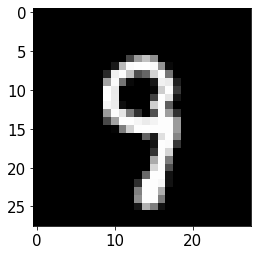

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


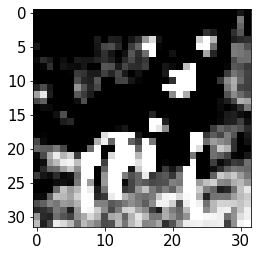

In [41]:
# class to download and maintain datasets
class DataSet():
  def __init__(self, name, subset_size, batch_size, test_size, key):
    self.name = name
    self.subset_size = subset_size 
    self.num_classes = 10
    if name == 'CIFAR10':
      self.total_size = 50000
      self.dim = 1024
    elif name == 'CIFAR100':
      self.total_size = 50000
      self.dim = 1024
      self.num_classes = 100
    elif name == 'MNIST':
      self.total_size = 60000
      self.dim = 784
    else:
      raise Exception('No valid dataset is chosen') 

    self.batch_size = batch_size
    self.key = key
    self.subset_inds = random.shuffle(key, np.arange(self.total_size))[0:subset_size]
    self.test_size = test_size
    self.all_data = npo.zeros((self.total_size, self.dim))
    self.all_labels = npo.zeros((self.total_size, self.num_classes))
    self.all_test_data = npo.zeros((self.test_size, self.dim))
    self.all_test_labels = npo.zeros((self.test_size, self.num_classes))
    return

  # processes data into np arrays
  def process_data(self, batch_block):
    image, label = batch_block['image'], batch_block['label']
    samples = image.shape[0]
    if image.shape[3] == 3:
      image = tf.image.rgb_to_grayscale(tf.image.per_image_standardization(image)).numpy()
    
    ## Normalize the images to zero mean and unit norm
    image = np.reshape(image, (image.shape[0], self.dim))
    image = image.T - np.mean(image, axis = 1)
    image = image / np.linalg.norm(image, axis = 0)

    label = np.eye(self.num_classes)[label]
    return {'image': image.T, 'label': label} 

  def download_and_process(self):
    batch_size = self.batch_size
    if self.name =='CIFAR10':
      test_data = tfds.load('cifar10', split=tfds.Split.TEST)
      train_data = tfds.load('cifar10', split=tfds.Split.TRAIN)
    elif self.name == 'CIFAR100':
      test_data = tfds.load('cifar100', split=tfds.Split.TEST)
      train_data = tfds.load('cifar100', split=tfds.Split.TRAIN)
    else:
      test_data = tfds.load('mnist', split=tfds.Split.TEST)
      train_data = tfds.load('mnist', split=tfds.Split.TRAIN)
    train_data_shuff = tfds.as_numpy(train_data.shuffle(1024).batch(batch_size))
    test_data_shuff = tfds.as_numpy(test_data.shuffle(1024).batch(batch_size)) 

    for i,batch in enumerate(train_data_shuff):
      datai = self.process_data(batch)
      self.all_data[i*batch_size:(i+1)*batch_size,:] = datai['image']
      self.all_labels[i*batch_size:(i+1)*batch_size,:] = datai['label']
    
    for i,batch in enumerate(test_data_shuff):
      datai = self.process_data(batch)
      self.all_test_data[i*batch_size:(i+1)*batch_size,:] = datai['image']
      self.all_test_labels[i*batch_size:(i+1)*batch_size,:] = datai['label']
    
    return
  
  # gets a subset of the data to train/test on
  def get_subset(self):
    train_sub = self.all_data[self.subset_inds,:]
    labels_sub = self.all_labels[self.subset_inds,:]
    return (train_sub, labels_sub)


def test_dataset_class(dataset_name, img_num):

  key = random.PRNGKey(0)
  test_size = 10000
  subset_size = 500
  batch_size = 500
  dataset = DataSet(dataset_name, subset_size, batch_size, test_size, key)
  dataset.download_and_process()

  dim = np.sqrt(dataset.dim).astype('int')

  x = dataset.all_data.reshape(dataset.total_size,dim,dim)
  y = dataset.all_labels

  print(y[img_num])
  plt.imshow(x[img_num], cmap='gray');
  plt.show()

test_dataset_class('MNIST',10)
test_dataset_class('CIFAR10',10)

# Theory Curves

In [20]:
## Gaussian kernel function
def gaussian_kernel(X, Xp, ker_var):
    G1 = np.dot(X, X.T)
    G2 = np.dot(Xp, Xp.T)
    G3 = np.dot(X, Xp.T)
    R = np.outer(np.diag(G1), np.ones(Xp.shape[0])) + np.outer(np.ones(X.shape[0]), np.diag(G2)) - 2*G3
    K = np.exp(-0.5*R / ker_var**2)
    
    return K

class Theory_Gaussian():

  def __init__(self, expt):
    self.expt = expt
    self.ker_var = expt.ker_var
    self.lamb = expt.lamb
    self.label_dim = expt.dataset.num_classes
    self.results = []
    return
  
  ## Perform eigendecomposition of kernel Gram matrix
  def get_spectrum_vecs(self, subset_size):

    ker_var = self.ker_var
    X = self.expt.dataset.all_data[self.expt.dataset.subset_inds,:]
    y = self.expt.dataset.all_labels[self.expt.dataset.subset_inds,:]
    num_pca = len(self.expt.dataset.subset_inds)
    assert(subset_size == num_pca)

    results = []
    spectra = []
    target_spectra = []
    for i, var in enumerate(ker_var):
      K = gaussian_kernel(X, X, var)/subset_size

      spectrum, vecs = np.linalg.eigh(K)
      inds = npo.argsort(spectrum)[::-1]
      spectrum = npo.abs(spectrum[inds] * (spectrum[inds] > 0))
      vecs = vecs*npo.sqrt(subset_size)
      vecs = vecs[:,inds]
      print('top_eigvalue: ', spectrum[0], 'top_eigvector: ', vecs[:,0])
      coeffs = npo.dot(vecs.T, y)/subset_size
      weight_sq = npo.sum(coeffs**2, axis = 1)

      eig_zero = spectrum[0]
      weight_sq_zero = weight_sq[0]
      spec = spectrum
      weight_sq = weight_sq

      result = {'spectrum': spec, 'weight_sq': weight_sq}
      results += [result]
    self.results = results
    ## Plot eigenspectrum and weights
    fig, axs = plt.subplots(1,len(ker_var)+1)
    fig.set_size_inches(4*(len(ker_var)+1),4)
    for i in range(len(ker_var)):
      spec = results[i]['spectrum']
      weight_sq = results[i]['weight_sq']
      axs[i].set_title('ker_var = %0.01f'%ker_var[i])
      axs[i].loglog(spec,label='spectrum')
      axs[i].loglog(weight_sq, label='power')
      axs[i].legend()
    axs[-1].set_visible(False)
    plt.show()

    return results 
  
  def theory_learning_curves(self, pvals):

    all_errs = npo.zeros((len(self.ker_var), len(self.lamb), len(self.expt.noise_std), len(pvals)))
    variance = npo.zeros((len(self.ker_var), len(self.lamb), len(self.expt.noise_std), len(pvals)))
    bias = npo.zeros((len(self.ker_var), len(self.lamb), len(self.expt.noise_std), len(pvals)))
    train_errs = npo.zeros((len(self.ker_var), len(self.lamb), len(self.expt.noise_std), len(pvals)))

    ker_var = self.ker_var
    lamb = self.lamb
    noise_std = self.expt.noise_std
    num_pca = len(self.expt.dataset.subset_inds)

    for i, var in enumerate(ker_var):
      r = self.results[i]
      spectrum = r['spectrum']
      weight_sum = r['weight_sq']

      for j, reg in enumerate(lamb):
        print("ker_var: %0.2f | lamb = %.2e | spectral max: %.5f  | min: %.5f" % (var, reg, npo.amax(spectrum), npo.amin(spectrum)))
        ## Solve implicit equation
        kappa_vals = ker_sim.solve_kappa(pvals, reg, spectrum)
        gamma_vals= npo.array([ker_sim.gamma_fn(pvals[i], kappa_vals[i], spectrum).sum() for i in range(len(pvals))])
        plt.loglog(pvals, kappa_vals)
        plt.loglog(pvals, gamma_vals)
        plt.show()
        
        ## Calculate generalization error
        noiseless = npo.zeros(len(pvals))
        zero_mode_err = npo.zeros(len(pvals))
        prefactor = kappa_vals**2/(1 - gamma_vals)

        for l, p in enumerate(pvals):
          noiseless[l] = prefactor[l] * npo.sum(weight_sum[1:]/(p*spectrum[1:] + kappa_vals[l])**2)
          zero_mode_err[l] = prefactor[l] * weight_sum[0]/(2*p*spectrum[0]+kappa_vals[l])**2*(1+gamma_vals[l])

        noiseless = noiseless + zero_mode_err
        for k, noise in enumerate(noise_std):
          noise_error = (noise**2*self.label_dim) * gamma_vals/(1 - gamma_vals)
          gen_err = noiseless + noise_error
          all_errs[i,j,k] = gen_err
          variance[i,j,k] = gamma_vals*noiseless + noise_error
          bias[i,j,k] = (1 - gamma_vals)*noiseless
          train_errs[i,j,k] = reg**2/kappa_vals**2 * (gen_err + noise**2*self.label_dim)

    return all_errs, train_errs, bias, variance

# Experiment Functions

In [21]:
####### Gaussian Generalization ############
## Gaussian kernel (note the relative factor of 1/dimension)
## This is the original form of the kernel in the paper
## However, in calculating theoretical curves using KPCA, 
## we cannot calculate the degeneracy associated to each 
## eigenvector. Hence we remove this factor and the corresponding
## eigenvalues above becomes the scaled eigenvalues \bar \eta_K.
## See SI.4.1 - Gaussian Kernel

def gaussian_kernel(X, Xp, ker_var):
    G1 = np.dot(X, X.T)
    G2 = np.dot(Xp, Xp.T)
    G3 = np.dot(X, Xp.T)
    R = np.outer(np.diag(G1), np.ones(Xp.shape[0])) + np.outer(np.ones(X.shape[0]), np.diag(G2)) - 2*G3
    K = np.exp(-0.5*R / ker_var**2 / X.shape[1])
    return K

def gaussian_regression(key, X, y, noise_std, pvals, ker_var, lamb, num_avg, bv_trial):

    keys = random.split(key, num_avg)

    errs = npo.zeros((bv_trial, num_avg, len(pvals)))
    errs_train = npo.zeros((bv_trial, num_avg, len(pvals)))

    bias = npo.zeros((num_avg, len(pvals)))
    var = npo.zeros((num_avg, len(pvals)))
    gaussian_kernel_jit = jit(gaussian_kernel)

    # Specify the test samples
    Xtest = X
    ytest = y

    for i, p in enumerate(pvals):
        print('p: ' + str(p), end = '\r')
        for j in range(num_avg):
            train_keys = random.split(keys[j], bv_trial)
            yhat = npo.zeros((bv_trial, y.shape[0], y.shape[1]))
            for k in range(bv_trial):
              # Specify the training samples with noisy labels
              shuff_inds = random.shuffle(train_keys[k], np.arange(len(y)))
              inds_tr = shuff_inds[0:p]
              Xtrain = X[inds_tr,:]
              ytrain_noiseless = y[inds_tr,:]
              ytrain = ytrain_noiseless + npo.random.normal(0, noise_std, ytrain_noiseless.shape)

              ## Performing regression
              K = gaussian_kernel_jit(Xtrain, Xtrain, ker_var)
              alpha = np.dot(np.linalg.inv(K + lamb*np.eye(p)), ytrain)
              yhat_train = np.dot(K, alpha)

              Ktest_hat = gaussian_kernel_jit(Xtest, Xtrain, ker_var)
              yhat[k] = np.dot(Ktest_hat, alpha)

              errs_train[k,j,i] = np.linalg.norm(yhat_train -  ytrain)**2 / ytrain.shape[0]
              errs[k,j,i] = np.linalg.norm(yhat[k] -  ytest)**2 / ytest.shape[0]
        
            var[j,i] = yhat.var(axis = 0).sum() / ytest.shape[0]
            bias[j,i] = np.sum((yhat.mean(axis = 0) - ytest)**2) / ytest.shape[0]

    errs = errs.reshape(errs.shape[0]*errs.shape[1], errs.shape[2])
    errs_std = errs.std(axis=0)
    errs = errs.mean(axis=0)
    errs_train = errs_train.reshape(errs_train.shape[0]*errs_train.shape[1], errs_train.shape[2])
    errs_tr_std = errs_train.std(axis=0)
    errs_tr = errs_train.mean(axis=0)

    var_std = var.std(axis=0)
    var = var.mean(axis=0)
    bias_std = bias.std(axis=0)
    bias = bias.mean(axis=0)

    return errs, errs_std, errs_tr, errs_tr_std, bias, bias_std, var, var_std

class Experiment():
  def __init__(self, dataset, num_repeats, pvals, noise_std, ker_var, lamb):
    self.dataset = dataset
    self.key = dataset.key
    self.num_repeats = num_repeats
    self.pvals = pvals
    self.noise_std = noise_std
    self.ker_var = ker_var
    self.lamb = lamb
    return

  def Gaussian_train(self, bv_trial = 150):

    key = self.key
    dataset = self.dataset.get_subset()
    pvals = self.pvals

    ker_var = self.ker_var
    lamb = self.lamb
    noise_std = self.noise_std
    num_avg = self.num_repeats
    
    all_errs = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_stds = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_tr_errs = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_tr_stds = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))

    all_var = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_var_stds = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_bias = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))
    all_bias_stds = npo.zeros((len(ker_var), len(lamb), len(noise_std), len(self.pvals)))

    tot_time_start = datetime.now()
    for i, var in enumerate(ker_var):
      for j, reg in enumerate(lamb):
        for k, noise in enumerate(noise_std):
          print('******** ker_var: %0.2e, lamb: %0.2e, noise: %0.2e ************' % (var, reg, noise))
          errs, stds, errs_tr, stds_tr, errs_bias, errs_bias_std, errs_var, errs_var_std = gaussian_regression(key, *dataset, noise, pvals, var, reg, num_avg, bv_trial)
          all_errs[i,j,k] = errs
          all_stds[i,j,k] = stds
          all_tr_errs[i,j,k] = errs_tr
          all_tr_stds[i,j,k] = stds_tr

          all_bias[i,j,k] = errs_bias
          all_bias_stds[i,j,k] = errs_bias_std
          all_var[i,j,k] = errs_var
          all_var_stds[i,j,k] = errs_var_std

    tot_time_end = datetime.now()
    print('Total Time for Gaussian Regression with P = %d: ' % np.amax(self.pvals) + time_diff(tot_time_start, tot_time_end))

    return all_errs, all_stds, all_tr_errs, all_tr_stds, all_bias, all_bias_stds, all_var, all_var_stds

# Perform Experiments

Experiment Start Time:  02-23_02-17
******** ker_var: 1.00e-01, lamb: 1.00e-02, noise: 0.00e+00 ************
******** ker_var: 1.00e-01, lamb: 1.00e-02, noise: 7.07e-01 ************
Total Time for Gaussian Regression with P = 6354: 0h 2m 28s


/usr/local/lib/python3.6/dist-packages/jax/_src/numpy/lax_numpy.py:3939: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


top_eigvalue:  0.9144631 top_eigvector:  [1.005626   0.99971753 0.99198276 ... 0.98922634 0.9929547  0.9998925 ]


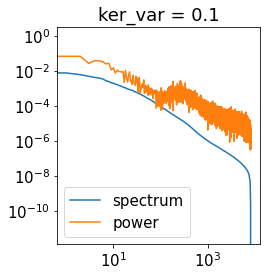

ker_var: 0.10 | lamb = 1.00e-02 | spectral max: 0.91446  | min: 0.00000


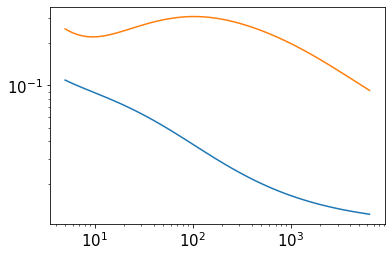

Experiment End Time:  02-23_02-20


In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

time_exp_start = datetime.now(pytz.timezone('US/Eastern'))
timestamp = time_exp_start.strftime("%m-%d_%H-%M")
print('Experiment Start Time: ', timestamp)

dataset_name ='MNIST'
expt_decorator = dataset_name + '_vary_reg_noise'

key = random.PRNGKey(0)
test_size = 10000
subset_size = 8000
batch_size = 100
d_mnist = DataSet(dataset_name, subset_size, batch_size, test_size, key)
d_mnist.download_and_process()

## Must set bv_trial to large numbers for better fit with bias theory (around 150)
bv_trial = 10 # bias-variance trial

num_repeats = 5
pvals = npo.logspace(0.7, np.log10(subset_size)-0.1, 20).astype('int')

# ker_var = [0.08, 0.1, 0.5]
# lamb = [0.01, 0.1]
# noise_std = np.sqrt(np.array([0, 0.5, 1, 1.5, 2, 2.5]))

ker_var = [0.1]
lamb = [0.01]
noise_std = np.sqrt(np.array([0, 0.5]))

params = {'dataset_name': dataset_name,
 'test_size': test_size,
 'subset_size': subset_size,
 'batch_size': batch_size,
 'num_repeats': num_repeats,
 'noise_std': noise_std,
 'ker_var': ker_var,
 'lamb': lamb}

## Regression Learning Curves ###
gauss_expt = Experiment(d_mnist, num_repeats, pvals, noise_std, ker_var, lamb)
errs_ker, stds_ker, errs_tr_ker, stds_tr_ker, bias_ker, bias_ker_stds, var_ker, var_ker_stds = gauss_expt.Gaussian_train(bv_trial)
if save_data:
  filename_RBF = save_dir + timestamp + expt_decorator + '_Gauss_experiment_final.npz'
  np.savez(filename_RBF, pvals, errs_ker, stds_ker, errs_tr_ker, stds_tr_ker, bias_ker, bias_ker_stds, var_ker, var_ker_stds)

## Theory Learning Curves ###
ptheory = np.logspace(0.7, np.log10(subset_size)-0.1, 100)
t = Theory_Gaussian(gauss_expt)
results = t.get_spectrum_vecs(subset_size) # Get the spectrum
errs_theory, errs_tr_theory, bias_theory, var_theory = t.theory_learning_curves(ptheory) # Get the theory learning curves

spectrum = npo.zeros((len(results), len(results[0]['spectrum'])))
weights = npo.zeros((len(results), len(results[0]['spectrum'])))
for i, r in enumerate(results):
  spectrum[i,:] = r['spectrum']
  weights[i,:] = r['weight_sq']

if save_data:
  filename_Theory = save_dir + timestamp + expt_decorator + '_Gauss_theory_final.npz'
  np.savez(filename_Theory, ptheory, spectrum, weights, errs_theory, errs_tr_theory, bias_theory, var_theory, params)

time_exp_end = datetime.now(pytz.timezone('US/Eastern'))
print('Experiment End Time: ', time_exp_end.strftime("%m-%d_%H-%M"))

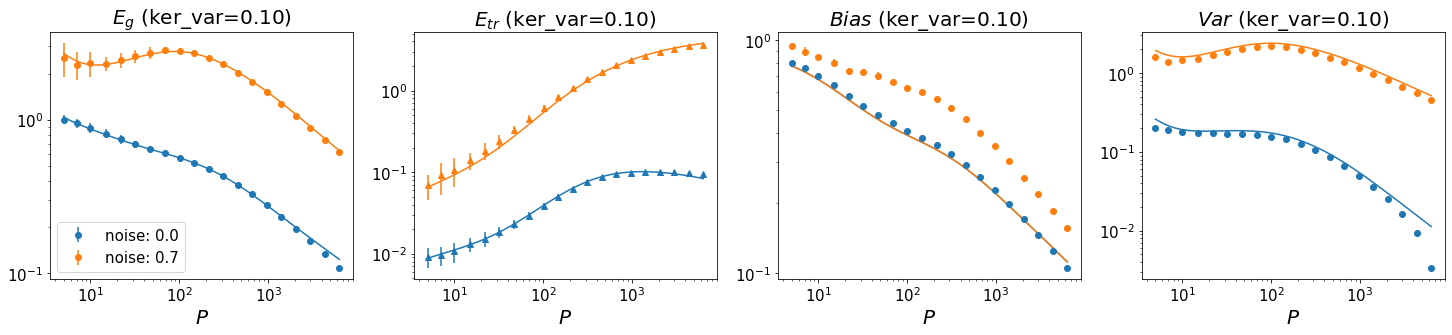

In [33]:
## Plotting the curves for Eg, Etr, bias and variance for each ker_var

plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(len(ker_var)+1, 4)
fig.set_size_inches(25,5*(len(ker_var)+1))

## Specify the regularization index for plotting
j = reg_idx = 0

for i, var in enumerate(ker_var):
  for k, noise in enumerate(noise_std):
    theory = errs_theory[i,j,k]
    train_theory = errs_tr_theory[i,j,k]
    bias = bias_theory[i,j,k]
    variance = var_theory[i,j,k]

    exp = errs_ker[i,j,k]
    std = stds_ker[i,j,k]
    exp_tr = errs_tr_ker[i,j,k]
    std_tr = stds_tr_ker[i,j,k]
    exp_bias = bias_ker[i,j,k]
    exp_bias_std = bias_ker_stds[i,j,k]
    exp_var = var_ker[i,j,k]
    exp_var_std = var_ker_stds[i,j,k]

    axs[i,0].plot(ptheory, bias + variance, color = 'C%d' % (k))
    axs[i,0].errorbar(pvals, exp_bias + exp_var, std, fmt='o', color = 'C%d' % (k), label = 'noise: %0.1f' %(noise_std[k]))
    axs[i,0].set_xlabel(r'$P$', fontsize=20)
    axs[i,0].set_title(r'$E_g$ (ker_var=%0.2f)' %var, fontsize=20)
    axs[i,0].set_xscale('log')
    axs[i,0].set_yscale('log')
    axs[i,0].legend()

    axs[i,1].plot(ptheory, train_theory, color = 'C%d' % (k))
    axs[i,1].errorbar(pvals, exp_tr, std_tr, fmt='^', color = 'C%d' % (k))
    axs[i,1].set_xlabel(r'$P$', fontsize=20)
    axs[i,1].set_title(r'$E_{tr}$ (ker_var=%0.2f)' %var, fontsize=20)
    axs[i,1].set_xscale('log')
    axs[i,1].set_yscale('log')

    axs[i,2].plot(ptheory, bias, color = 'C%d' % (k))
    axs[i,2].errorbar(pvals, exp_bias, exp_bias_std, fmt='o', color = 'C%d' % (k), label = 'bias_noise: %0.1f' %(noise_std[k]))
    axs[i,2].set_xlabel(r'$P$', fontsize=20)
    axs[i,2].set_title(r'$Bias$ (ker_var=%0.2f)' %var, fontsize=20)
    axs[i,2].set_xscale('log')
    axs[i,2].set_yscale('log')

    axs[i,3].plot(ptheory, variance, color = 'C%d' % (k))
    axs[i,3].errorbar(pvals, exp_var, exp_var_std, fmt='o', color = 'C%d' % (k), label = 'var_noise: %0.1f' %(noise_std[k]))
    axs[i,3].set_xlabel(r'$P$', fontsize=20)
    axs[i,3].set_title(r'$Var$ (ker_var=%0.2f)' %var, fontsize=20)
    axs[i,3].set_xscale('log')
    axs[i,3].set_yscale('log')

axs[-1,0].set_visible(False)
axs[-1,1].set_visible(False)
axs[-1,2].set_visible(False)
axs[-1,3].set_visible(False)
plt.show()

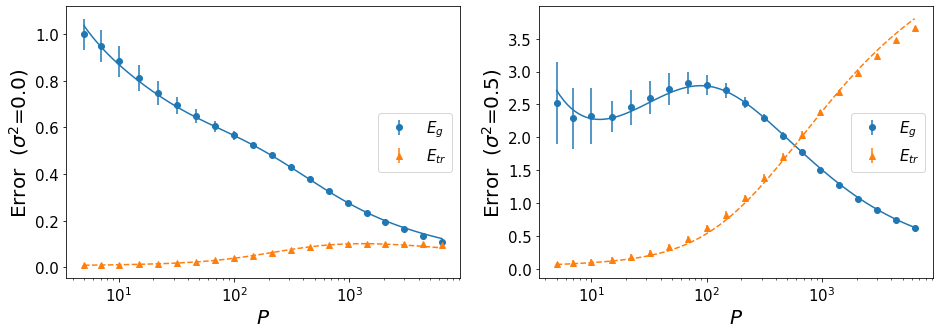

In [38]:
## Plotting the curves for Eg and Etr together

plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1,len(noise_std) + 1)
fig.set_size_inches(12*len(noise_std),5)

## Specify the regularization index for plotting
j = reg_idx = 0

for i, var in enumerate(ker_var):
  for k, noise in enumerate(noise_std):
    theory = errs_theory[i,j,k]
    train_theory = errs_tr_theory[i,j,k]
    exp = errs_ker[i,j,k]
    std = stds_ker[i,j,k]
    exp_tr = errs_tr_ker[i,j,k]
    std_tr = stds_tr_ker[i,j,k]
    
    axs[k].plot(ptheory, theory, color = 'C%d' % (0))
    axs[k].errorbar(pvals, exp, std, fmt='o', color = 'C%d' % (0), label = '$E_g$' %(noise_std[k]))
    axs[k].set_xlabel(r'$p$', fontsize=20)
    axs[k].set_xscale('log')
    #axs[i].set_yscale('log')

    axs[k].plot(ptheory, train_theory, '--',color = 'C%d' % (1))
    axs[k].errorbar(pvals, exp_tr, std_tr, fmt='^', color = 'C%d' % (1), label='$E_{tr}$')
    axs[k].set_xlabel(r'$P$', fontsize=20)
    axs[k].set_ylabel(r'Error  ($\sigma^2$=%0.1f)' %noise**2, fontsize=20)
    axs[k].set_xscale('log')
    axs[k].legend(loc='center right')

axs[-1].set_visible(False)
plt.show()